# Predicting Prices of AirBnB’s in New York City
### Nick Pacia (snp43), Lindsay Kim (ek532), Sooyeon Kim (sk2696)

## Load Data

In [342]:
!pip install -U scikit-learn==1.2

In [343]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

# Set default figure size and dpi
mpl.rcParams['figure.figsize']= (7,5)
mpl.rcParams['figure.dpi']= 110

In [344]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [345]:
# import os
# os.chdir("/content/drive/My Drive/AML Final Project")
# !ls

In [346]:
df = pd.read_csv("AB_NYC_2019.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

## Preprocessing

In [347]:
# drop irrelevant columns and rename some
df = df.drop(["host_name", "host_id", "last_review", "id"], axis = 1)
df = df.rename({"neighbourhood_group": "borough", 
                "neighbourhood": "neighborhood"}, axis = 1)

# fill na reviews_per_month with median reviews_per_month
med = df["reviews_per_month"].median()
df["reviews_per_month"] = df["reviews_per_month"].fillna(med) 

# delete rows with price of 0
df = df[df['price']!= 0]

In [348]:
df.head()

,name,borough,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.72,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


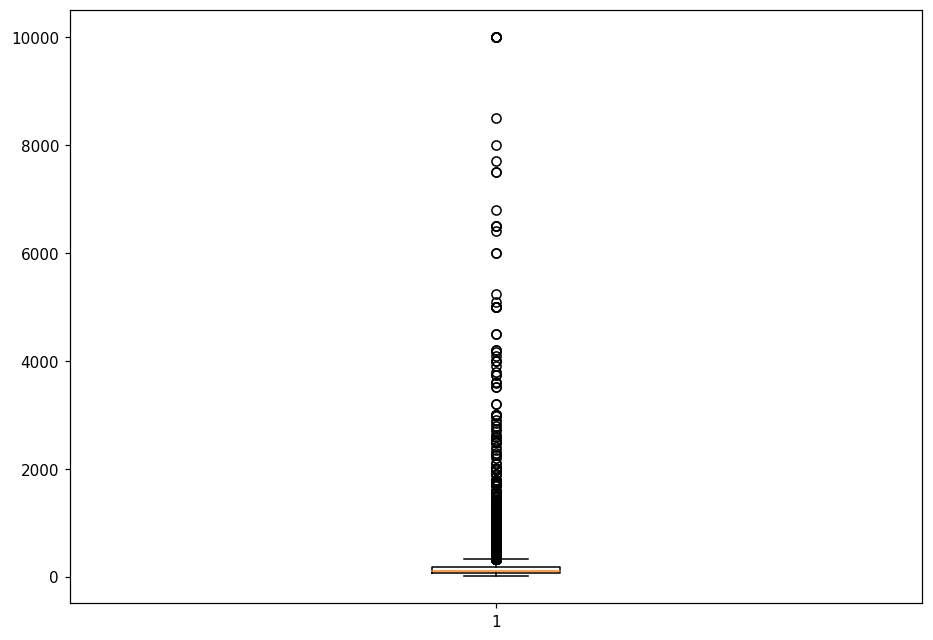

In [349]:
fig, ax = plt.subplots(figsize=(10,7))
plt.boxplot(df['price'])
plt.show()

In [350]:
def find_outliers_IQR(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [351]:
outliers = find_outliers_IQR(df['price'])
print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
outliers

number of outliers: 2972
max outlier value: 10000
min outlier value: 335


61       375
85       800
103      500
114      350
121      400
        ... 
48758    350
48833    475
48839    800
48842    350
48856    345
Name: price, Length: 2972, dtype: int64

In [352]:
outliers = find_outliers_IQR(df['minimum_nights'])
print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
outliers

number of outliers: 6605
max outlier value: 1250
min outlier value: 12


6        45
14       90
29       14
36       60
45       29
         ..
48810    30
48843    29
48871    29
48879    20
48882    20
Name: minimum_nights, Length: 6605, dtype: int64

In [353]:
outliers = find_outliers_IQR(df['number_of_reviews'])
print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
outliers

number of outliers: 6018
max outlier value: 629
min outlier value: 59


3        270
5         74
7        430
8        118
9        160
        ... 
40104     65
40297     95
40424     65
42075    156
42076     82
Name: number_of_reviews, Length: 6018, dtype: int64

In [354]:
outliers = find_outliers_IQR(df['reviews_per_month'])
print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
outliers

number of outliers: 4100
max outlier value: 58.5
min outlier value: 3.54


3        4.64
18       4.44
67       4.72
113      4.22
137      3.89
         ... 
47848    5.00
47967    6.00
48031    7.00
48228    5.00
48252    4.00
Name: reviews_per_month, Length: 4100, dtype: float64

In [355]:
outliers = find_outliers_IQR(df['calculated_host_listings_count'])
print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
outliers

number of outliers: 7073
max outlier value: 327
min outlier value: 4


0        6
9        4
21       6
22       6
23       6
        ..
48858    4
48867    6
48868    6
48878    5
48893    6
Name: calculated_host_listings_count, Length: 7073, dtype: int64

In [356]:
outliers = find_outliers_IQR(df['availability_365'])
print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
outliers

number of outliers: 0
max outlier value: nan
min outlier value: nan


Series([], Name: availability_365, dtype: int64)

In [357]:
def impute_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    upper = df[~(df>(q3+1.5*IQR))].max()
    lower = df[~(df<(q1-1.5*IQR))].min()
    df = np.where(df > upper, df.mean(), np.where(df < lower, df.median(), df))
    return df

In [358]:
df['price'] = impute_outliers_IQR(df['price'])
df['minimum_nights'] = impute_outliers_IQR(df['minimum_nights'])
df['number_of_reviews'] = impute_outliers_IQR(df['number_of_reviews'])
df['reviews_per_month'] = impute_outliers_IQR(df['reviews_per_month'])
df['calculated_host_listings_count'] = impute_outliers_IQR(df['calculated_host_listings_count'])
df

,name,borough,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1.0,9.000000,0.210000,7.144628,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45.000000,0.380000,2.000000,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0.000000,0.720000,1.000000,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,23.271991,1.238839,1.000000,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9.000000,0.100000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70.0,2.0,0.000000,0.720000,2.000000,9
48891,Affordable room in Bushwick/East Williamsburg,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40.0,4.0,0.000000,0.720000,2.000000,36
48892,Sunny Studio at Historical Neighborhood,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115.0,10.0,0.000000,0.720000,1.000000,27
48893,43rd St. Time Square-cozy single bed,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55.0,1.0,0.000000,0.720000,7.144628,2


In [359]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,40.728953,-73.952176,121.990529,3.288876,11.335362,0.915085,2.141968,112.779498
std,0.054532,0.046159,66.491669,2.274036,13.286223,0.810454,2.128049,131.627271
min,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983080,69.000000,1.000000,1.000000,0.280000,1.000000,0.000000
50%,40.723080,-73.955685,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763120,-73.936290,152.755053,5.000000,23.271991,1.238839,2.000000,227.000000
max,40.913060,-73.712990,334.000000,11.000000,58.000000,3.530000,7.144628,365.000000


In [360]:
def regex_clean(string):

    string = str(string)

    # set all chars to lowercase
    string = string.lower() 

    # replace w/ with with
    with_pattern = re.compile(r"w/") 
    string = re.sub(with_pattern, "with", string)

    # strip special characters
    string = string.replace('-', ' ')
    string = string.replace("'", "")
    string = re.sub(r'[^\w\s]', ' ', string)

    # replace extra spaces with single spaces
    doublespace_pattern = re.compile(r"\s{2,}") 
    string = re.sub(doublespace_pattern, ' ', string)

    # strip extra spaces from beginning and end of string
    string = string.strip() 
    
    return string

df["name"] = df["name"].apply(regex_clean)
df["name"]

0                        clean quiet apt home by the park
1                                   skylit midtown castle
2                          the village of harlem new york
3                         cozy entire floor of brownstone
4         entire apt spacious studio loft by central park
                               ...                       
48890       charming one bedroom newly renovated rowhouse
48891       affordable room in bushwick east williamsburg
48892             sunny studio at historical neighborhood
48893                 43rd st time square cozy single bed
48894    trendy duplex in the very heart of hells kitchen
Name: name, Length: 48884, dtype: object

In [361]:
df = df.drop(["reviews_per_month", "calculated_host_listings_count"], axis = 1)

In [362]:
# split df into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop("price", axis = 1), 
                                                    df["price"], 
                                                    test_size = 0.3, 
                                                    random_state = 90) 

# split test set into development set and test set
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, 
                                                test_size = 0.5, 
                                                random_state = 90) 

# get training index
training_index = X_train.index 
# get development index
dev_index = X_dev.index 
# get test index
test_index = X_test.index 

# X_full = pd.concat([X_train, X_dev, X_test]) # reconstruct df
# y_full = pd.concat([y_train, y_dev, y_test])

## Exploratory Data Analysis

In [363]:
# i = 1
# plt.figure(figsize=(8,8))
# for feature in df.loc[:, ["latitude", "longitude", 'minimum_nights', 'availability_365',
#        'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']]:
#     plt.subplot(2, 4, i)
#     plt.title(feature, fontsize=10)
#     ax = sns.boxplot(data = df[feature])
#     plt.tight_layout()
#     i += 1
# plt.show()

/var/folders/dp/_pc3s4994bqbbsvrm8jrtt480000gn/T/ipykernel_1166/3426158519.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')


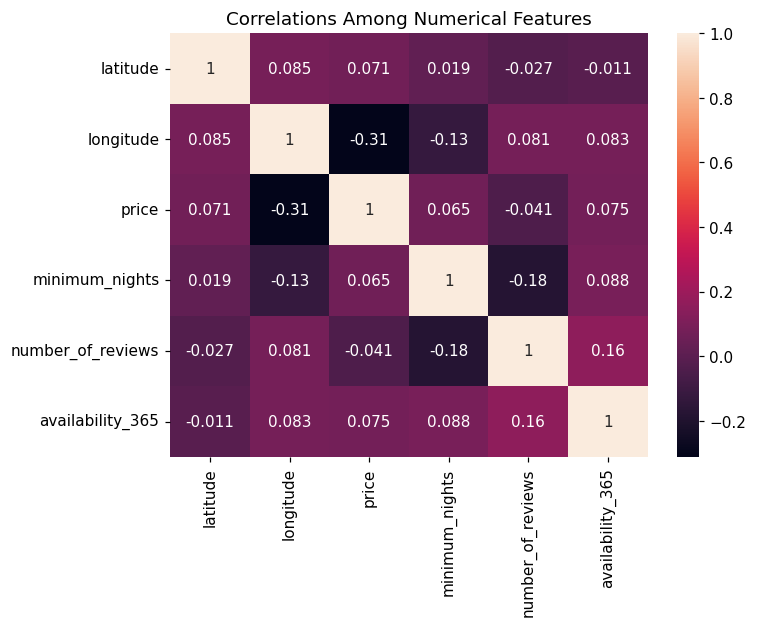

In [364]:
corr = df.corr(method='pearson')
sns.heatmap(corr, annot=True)
plt.title(label='Correlations Among Numerical Features')
plt.show()

In [365]:
# # Plot color coded scatterplot based on neighbourhood group
# sns.relplot(data=df, y="latitude", x="longitude", hue="borough", kind="scatter",
#             s=10)
# plt.title('NYC Airbnb Locations by Borough')
# plt.show()

In [366]:
numerical_features = ["latitude", "longitude", "minimum_nights", "number_of_reviews", "availability_365"]
categorical_features = ["borough", "neighborhood", "room_type"]
features = ["latitude", "longitude", "minimum_nights", "number_of_reviews", "availability_365", "borough", "neighborhood", "room_type"]

## Model Selection

In [367]:
# initialize BoW model
vectorizer = CountVectorizer(min_df=15, stop_words="english") 
# initialize scaler for numerical data
scaler = StandardScaler()
# ohe for categorical data
ohe = OneHotEncoder(sparse_output = False, handle_unknown = "ignore") 

column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, numerical_features),
    (ohe, categorical_features), 
    remainder = "drop"
)
    

In [368]:
# Define the function to return the SMAPE value
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

### Baseline Model: Linear Regression

In [369]:
# Linear Regression

linear_model = LinearRegression()

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [370]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

1853.8438270690615
1954.8101463008163


In [371]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

26.92905908308893
27.55124843242326


In [372]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5801356564338945
0.5519806319654699


In [256]:
column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, numerical_features),
    (ohe, categorical_features), 
    remainder = "drop"
)

linear_model = LinearRegression()

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [257]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

1853.8438270690615
1954.8101463008163


In [258]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

26.92905908308893
27.55124843242326


In [259]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5801356564338945
0.5519806319654699


Not great performance, our has a high bias. Seems to be a classic case of underfitting. We will first try to manually change our feature space, and see if this corrects any errors in the linear regression. Our pipeline includes a vectorizer for the title of the listing, our first hypothesis will be that the name of the listing is irrelevant to final price.

In [260]:
column_transformer = make_column_transformer\
(
    (scaler, ["latitude", "longitude", "minimum_nights", "number_of_reviews"]),
    (ohe, ["borough", "neighborhood", "room_type"]), 
    remainder = "drop"
)

linear_model = LinearRegression()

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [261]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

2160.366797756706
3.5727635391003144e+22


In [262]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

28.521514450334926
28.707661975189932


In [263]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5107133760904781
-8.18835151819503e+18


Our hypothesis was completely wrong, as removing our vectorizer from the pipeline increased our error by magnitudes. Our next hypothesis is that the neighborhood feature is "confusing" the model and not allowing it to be as expressive, since there's so many different neighborhoods.

In [264]:
X_train["neighborhood"].value_counts()

Williamsburg          2726
Bedford-Stuyvesant    2632
Harlem                1891
Bushwick              1732
Hell's Kitchen        1387
                      ... 
Howland Hook             1
Huguenot                 1
Breezy Point             1
New Dorp                 1
Neponsit                 1
Name: neighborhood, Length: 220, dtype: int64

In [265]:
column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, ["latitude", "longitude", "minimum_nights", "number_of_reviews"]),
    (ohe, ["borough", "room_type"]), 
    remainder = "drop"
)

linear_model = LinearRegression()

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [266]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

1975.5011501771496
2051.171742707531


In [267]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

27.986238053229048
28.587898938322382


In [268]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5525823256943014
0.5298956936369928


Removing the neighborhood feature increased the error, but not by much. Clearly the neighborhood feature is somewhat useful, but we still aren't entirely convinced that the neighborhood feature is not causing the model trouble, so we will try using the OneHotEncoders infrequent categories functionality to bundle all categories that appear less than x amount of times. It appears that the median number of appearances is 23, so we will set the infrequent category threshold to 10.

In [269]:
ohe_2 = OneHotEncoder(handle_unknown = "infrequent_if_exist", min_frequency = 10) 

column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, ["latitude", "longitude", "minimum_nights", "number_of_reviews"]),
    (ohe_2, ["borough", "neighborhood", "room_type"]), 
    remainder = "drop"
)

linear_model = LinearRegression()

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [270]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

1891.3797087189992
1983.633552438745


In [271]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

27.15804804701198
27.68603695699789


In [272]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.571634412651109
0.5453746481429723


We have successfully decreased the error by treating neighborhoods which appear less than 10 times as their own "infrequent" category, we will try increasing and lowering the frequency to see if it makes a difference.

In [273]:
ohe_2 = OneHotEncoder(handle_unknown = "infrequent_if_exist", min_frequency = 5) 

column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, ["latitude", "longitude", "minimum_nights", "number_of_reviews"]),
    (ohe_2, ["borough", "neighborhood", "room_type"]), 
    remainder = "drop"
)

linear_model = LinearRegression()

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [274]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

1886.0158156054295
1983.9617928583536


In [275]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

27.14413351885327
27.707342834388545


In [276]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5728492439266477
0.5452994193205546


Lowering it to 5 made a slight difference, but it's probably safe to say that it is not the neighborhoods tripping up the model. Perhaps it has something to do with the scaling. Since latitude and longitude data is already "naturally" scaled, let's try not scaling them.

In [277]:
# column_transformer = make_column_transformer\
# (
#     (vectorizer, "name"),
#     (scaler, ["minimum_nights", "number_of_reviews"]),
#     (ohe_2, ["borough", "room_type"]),
#     remainder = "passthrough"
# )

# linear_model = LinearRegression()

# pipeline = make_pipeline(column_transformer, linear_model)
# pipeline.fit(X_train, y_train)

# y_train_pred = pipeline.predict(X_train)
# y_dev_pred = pipeline.predict(X_dev)

In [278]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

1886.0158156054295
1983.9617928583536


In [279]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

27.14413351885327
27.707342834388545


In [280]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5728492439266477
0.5452994193205546


In [281]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

1886.0158156054295
1983.9617928583536
27.14413351885327
27.707342834388545
0.5728492439266477
0.5452994193205546


In [282]:
def create_list_based_on(current_list, base_list):
    return list(set(current_list).intersection(base_list))

In [322]:
from itertools import combinations

best_models = {}
features.append("name")

for n in range(1, len(features) + 1):
    feature_comb = list(combinations(features, n))
    best_models[str(n)] = ["", 100, 100, 0, 0]
    print(n)
    for comb in feature_comb:
        column_transformer = None
        scaled_features = create_list_based_on(comb, numerical_features)
        ohe_features = create_list_based_on(comb, categorical_features)
        if len(scaled_features) == 0 and len(ohe_features) == 0:
            continue
        if len(scaled_features) == 0:
            if "name" in comb:
                column_transformer = make_column_transformer\
                (
                    (vectorizer, "name"),
                    (ohe_2, ohe_features),
                    remainder = "drop"
                )
            else:
                column_transformer = make_column_transformer\
                (
                    (ohe_2, ohe_features),
                    remainder = "drop"
                )
        elif len(ohe_features) == 0:
            if "name" in comb:
                column_transformer = make_column_transformer\
                (
                    (vectorizer, "name"),
                    (scaler, scaled_features),
                    remainder = "drop"
                )
            else:
                column_transformer = make_column_transformer\
                (
                    (scaler, scaled_features),
                    remainder = "drop"
                )
        else:
            if "name" in comb:
                column_transformer = make_column_transformer\
                (
                    (vectorizer, "name"),
                    (scaler, scaled_features),
                    (ohe_2, ohe_features),
                    remainder = "drop"
                )
            else:
                column_transformer = make_column_transformer\
                (
                    (scaler, scaled_features),
                    (ohe_2, ohe_features),
                    remainder = "drop"
                )
        linear_model = LinearRegression()

        pipeline = make_pipeline(column_transformer, linear_model)
        pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_dev_pred = pipeline.predict(X_dev)
        
        rsq_train = r2_score(y_train, y_train_pred)
        rsq_dev = r2_score(y_dev, y_dev_pred)
        smape_train = smape(y_train, y_train_pred)
        smape_dev = smape(y_dev, y_dev_pred)
        
        if best_models[str(n)][4] < rsq_dev:
            best_models[str(n)][0] = comb
            best_models[str(n)][1] = smape_train
            best_models[str(n)][2] = smape_dev 
            best_models[str(n)][3] = rsq_train 
            best_models[str(n)][4] = rsq_dev

1
2
3
4
5
6
7
8
9


{'1': [('room_type',),
  33.10104600649273,
  33.54169795110232,
  0.3840855628141663,
  0.40035622297400897],
 '2': [('room_type', 'name'),
  28.937103842799253,
  30.020731958362326,
  0.5219185456301785,
  0.5151089960296729],
 '3': [('neighborhood', 'room_type', 'name'),
  27.35480551619482,
  27.976239705422245,
  0.5633773874133192,
  0.5627471743537374],
 '4': [('availability_365', 'neighborhood', 'room_type', 'name'),
  27.179090957106137,
  27.84368457676251,
  0.568094324843603,
  0.569187659956907],
 '5': [('minimum_nights',
   'availability_365',
   'neighborhood',
   'room_type',
   'name'),
  26.95254671531533,
  27.551060732543885,
  0.5744068216331213,
  0.5756514429569023],
 '6': [('minimum_nights',
   'number_of_reviews',
   'availability_365',
   'neighborhood',
   'room_type',
   'name'),
  26.949317979216218,
  27.45054767428118,
  0.5753206276226096,
  0.5780163022842792],
 '7': [('longitude',
   'minimum_nights',
   'number_of_reviews',
   'availability_365',
   

In [333]:
for key in best_models:
    for i in range(len(best_models[key])):
        if i == 0:
            print("\n", best_models[key][i])
        elif i == 1 or i == 2:
            print(round(best_models[key][i]/100, 4))
        else:
            print(round(best_models[key][i], 4))


 ('room_type',)
0.331
0.3354
0.3841
0.4004

 ('room_type', 'name')
0.2894
0.3002
0.5219
0.5151

 ('neighborhood', 'room_type', 'name')
0.2735
0.2798
0.5634
0.5627

 ('availability_365', 'neighborhood', 'room_type', 'name')
0.2718
0.2784
0.5681
0.5692

 ('minimum_nights', 'availability_365', 'neighborhood', 'room_type', 'name')
0.2695
0.2755
0.5744
0.5757

 ('minimum_nights', 'number_of_reviews', 'availability_365', 'neighborhood', 'room_type', 'name')
0.2695
0.2745
0.5753
0.578

 ('longitude', 'minimum_nights', 'number_of_reviews', 'availability_365', 'neighborhood', 'room_type', 'name')
0.2692
0.2743
0.5758
0.579

 ('longitude', 'minimum_nights', 'number_of_reviews', 'availability_365', 'borough', 'neighborhood', 'room_type', 'name')
0.2689
0.2736
0.5772
0.5795

 ('latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'availability_365', 'borough', 'neighborhood', 'room_type', 'name')
0.2688
0.2738
0.5773
0.5791


In [320]:
column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, ['minimum_nights','number_of_reviews','availability_365']),
    (ohe_2, ['neighborhood','room_type']),
    remainder = "drop"
)

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [321]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5753206271280983
0.5780159124266566


difference between successive iterations is less than 1e-3, 0.001, our EM algorithm terminates. We chose the threshold of 0.0001 because this difference is small enough to conclude that the marginal log likelihood has converged.

Not scaling latitude and longitude made no difference, so we can keep them unscaled to make our model marginally more efficient.

We believe we've exhausted the extent to which we can improve this model through preprocessing, so we've decided we must switch to another regression model. We need a more expressive regression model than linear regression. We will try an kernel ridge regression as it is far more expressive than simple linear regression.

In [301]:
from sklearn.kernel_ridge import KernelRidge

column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, numerical_features),
    (ohe_2, categorical_features),
    remainder = "drop"
)

linear_model = KernelRidge(degree = 4)

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [302]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

1867.9084881570282
1889.8475056735322


In [303]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

26.862781675154622
27.305098673022837


In [304]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.577022936340825
0.5800905563444566


Kernel ridge regression produced little improvement at the expense of low efficiency, our last resort is to systematically strip the model of features, in hopes that we will overfit rather than underfit.

In [289]:
# split df into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop("price", axis = 1), 
                                                    df["price"], 
                                                    test_size = 0.10, 
                                                    random_state = 90) 

# split test set into development set and test set
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, 
                                                test_size = 0.5, 
                                                random_state = 90) 

In [290]:
column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, ["minimum_nights", "number_of_reviews"]),
    (ohe_2, ["borough", "neighborhood", "room_type"]),
    remainder = "passthrough"
)

linear_model = LinearRegression()

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [291]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_dev, y_dev_pred))

1868.3426058603143
1896.698132815331


In [292]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5769246329000608
0.578568400179386


In [293]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

26.90627739169528
27.401953993274283


In [294]:
from sklearn.ensemble import RandomForestRegressor

column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, ["latitude", "longitude", "minimum_nights", "number_of_reviews"]),
    (ohe_2, ["borough", "neighborhood", "room_type"]),
    remainder = "passthrough"
)
  
rf_model = RandomForestRegressor(max_depth=20, n_estimators = 7, random_state=0)

pipeline = make_pipeline(column_transformer, rf_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [295]:
print(smape(y_train, y_train_pred))
print(smape(y_dev, y_dev_pred))

19.708177603854466
26.25443952852131


In [296]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.7738177530357847
0.5714685300466067


## Test

In [305]:
column_transformer = make_column_transformer\
(
    (vectorizer, "name"),
    (scaler, ["minimum_nights", "number_of_reviews", "availability_365"]),
    (ohe, ["neighborhood", "room_type"]), 
    remainder = "drop"
)

linear_model = LinearRegression()

pipeline = make_pipeline(column_transformer, linear_model)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_dev_pred = pipeline.predict(X_dev)

In [306]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_dev, y_dev_pred))

0.5759796086340216
0.5782208066561054


In [298]:
y_test_pred = pipeline.predict(X_test)

print(mean_squared_error(y_test, y_test_pred))

1927.305136245998


In [307]:
print(smape(y_test, y_test_pred))
print(r2_score(y_test, y_test_pred))

25.18176195118123
0.5647083523489469
